# EK Dra Flare Detection Analysis

Flare detection and analysis for EK Dra using TESS data


In [1]:
import os
import re
import sys
from pathlib import Path

import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set the project root
PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name in ['notebooks', 'src']:
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT))
from src.flarepy_EK_Dra import FlareDetector_EK_Dra


## Load data (all sectors)


In [2]:
# Data folder path
folder_path = PROJECT_ROOT / "data" / "TESS" / "EK_Dra"

# Load all FITS files
file_list = sorted(folder_path.glob("*.fits"))
print(f"Found {len(file_list)} FITS files")

# Create a detector for each sector
detectors = {}
for file_path in file_list:
    match = re.search(r'-s(\d{4})-', file_path.name)
    if match:
        sector = f"s{match.group(1)}"
        key = f"detector_{sector}"
        detectors[key] = FlareDetector_EK_Dra(file=str(file_path), process_data=True)
        print(f"Loaded {sector}: {detectors[key].flare_number} flares detected")

print(f"\nTotal detectors: {len(detectors)}")


Found 12 FITS files
Loaded s0014: 5 flares detected
Loaded s0015: 5 flares detected
Loaded s0016: 2 flares detected
Loaded s0021: 10 flares detected
Loaded s0022: 4 flares detected
Loaded s0023: 4 flares detected
Loaded s0041: 7 flares detected
Loaded s0048: 3 flares detected
Loaded s0049: 2 flares detected
Loaded s0075: 5 flares detected
Loaded s0076: 6 flares detected
Loaded s0077: 4 flares detected

Total detectors: 12


## Results summary


In [3]:
sum_flare_number = sum(d.flare_number for d in detectors.values())
sum_obs_time = sum(d.precise_obs_time for d in detectors.values())

print(f"Total flares: {sum_flare_number}")
print(f"Total observation time: {sum_obs_time:.2f} days")
print(f"Average flare frequency: {sum_flare_number / sum_obs_time:.2f} flares/day")


Total flares: 57
Total observation time: 279.50 days
Average flare frequency: 0.20 flares/day


## Visualization

### Light curve


/Users/daisukeyamashiki/Code/Research/kyoto-flare-detection/src/base_flare_detector.py:1136: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  leg = plt.legend(loc="upper right", fontsize=11)


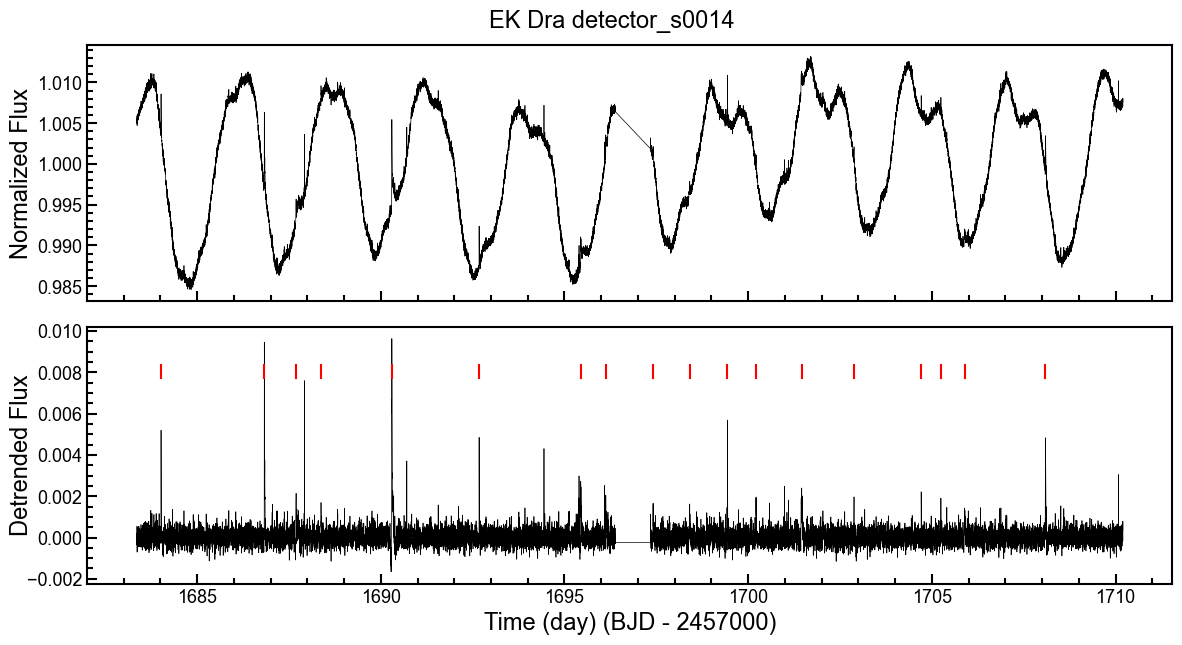

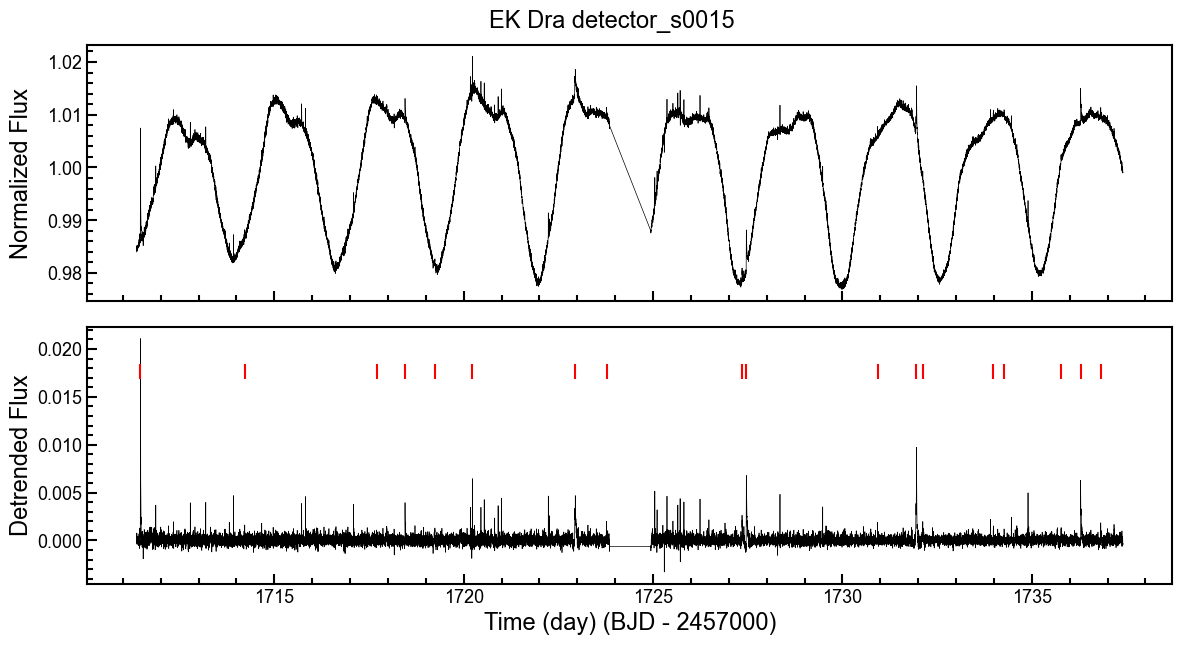

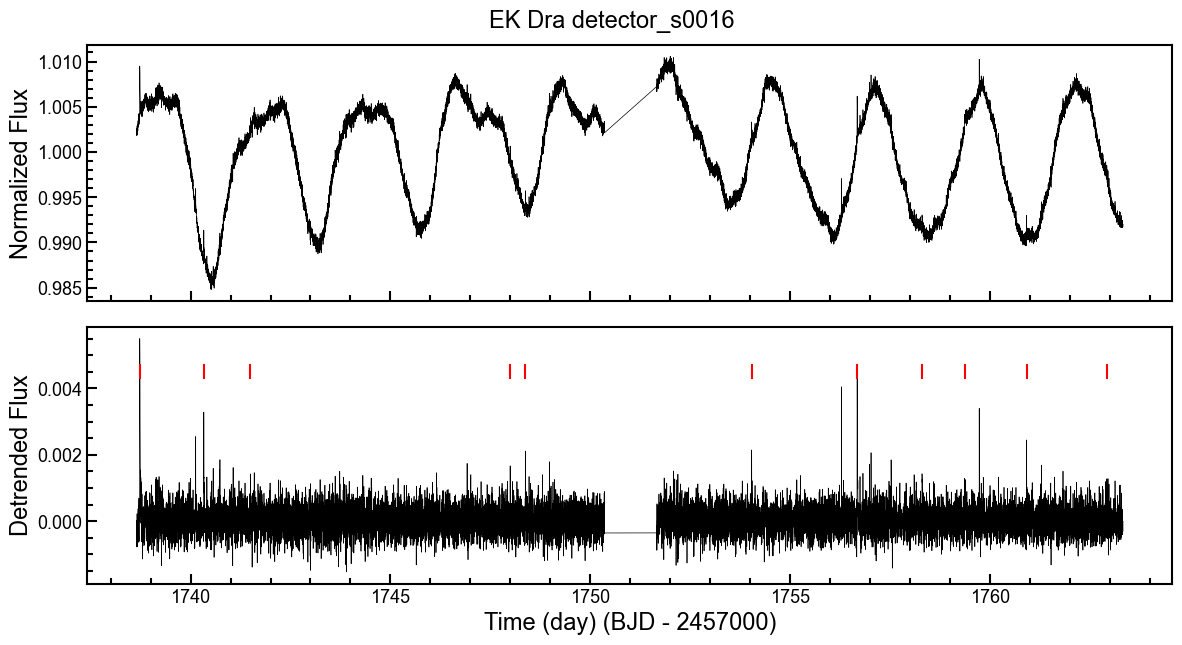

In [4]:
# Plot light curves for each sector
for name, detector in list(detectors.items())[:3]:  # Show only the first three
    detector.plt_flare(title=f"EK Dra {name}")


### Rotation period estimation (Gaussian fitting)


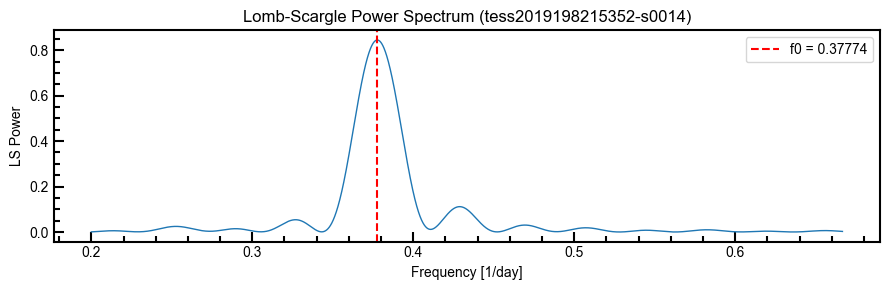

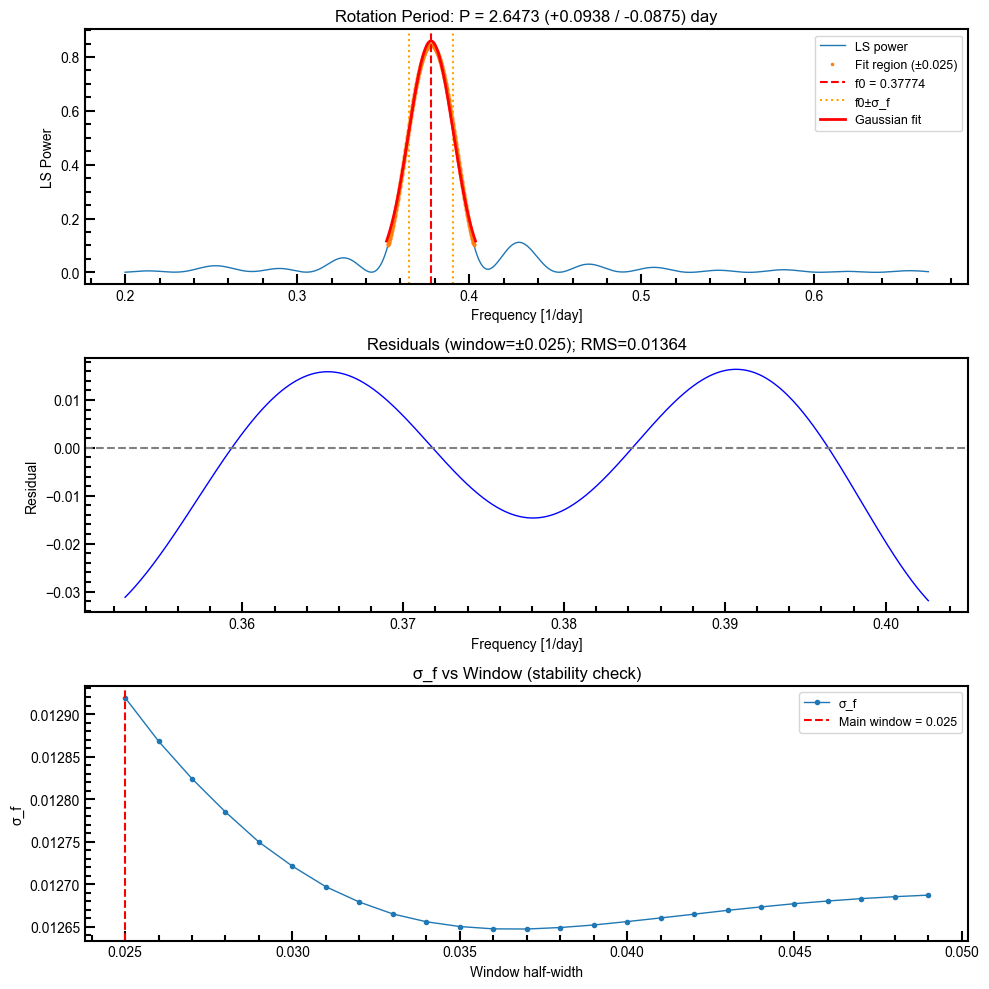


Estimated period: 2.6473 (+0.0938 / -0.0875) days


In [5]:
# Estimate the period for a representative sector (with diagnostic plots)
sample_detector = list(detectors.values())[0]
sample_detector.rotation_period(show_plot=True)

print(f"\nEstimated period: {sample_detector.per:.4f} (+{sample_detector.per_err_plus:.4f} / -{sample_detector.per_err_minus:.4f}) days")


### Energy distribution


In [6]:
# Energy distribution for each sector
for detector in list(detectors.values())[:3]:
    detector.plot_energy()


## Statistical analysis (class variables)


In [7]:
# Correlation between time and amplitude
fig = px.scatter(
    x=FlareDetector_EK_Dra.array_observation_time,
    y=FlareDetector_EK_Dra.array_amplitude,
    title="Observation time vs brightness variation amplitude",
    labels={"x": "Observation Time (BJD)", "y": "Amplitude"}
)
fig.show()


In [8]:
# Correlation between period and flare frequency
fig = px.scatter(
    x=FlareDetector_EK_Dra.array_per,
    y=FlareDetector_EK_Dra.array_flare_ratio,
    title="Rotation period vs flare frequency",
    labels={"x": "Period (days)", "y": "Flare Rate (flares/day)"}
)
fig.show()


In [9]:
# Correlation between amplitude and energy rate
fig = px.scatter(
    x=FlareDetector_EK_Dra.array_amplitude,
    y=FlareDetector_EK_Dra.array_energy_ratio,
    title="Brightness variation amplitude vs energy release rate",
    labels={"x": "Amplitude", "y": "Energy Rate (erg/day)"}
)
fig.show()


In [10]:
# Correlation between period and starspot area
fig = px.scatter(
    x=FlareDetector_EK_Dra.array_per,
    y=FlareDetector_EK_Dra.array_starspot,
    title="Rotation period vs starspot area",
    labels={"x": "Period (days)", "y": "Starspot Area"}
)
fig.show()


## Paper-quality figures


/Users/daisukeyamashiki/Code/Research/kyoto-flare-detection/src/base_flare_detector.py:1136: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Saved: /Users/daisukeyamashiki/Code/Research/kyoto-flare-detection/outputs/EK_Dra_lightcurve.pdf


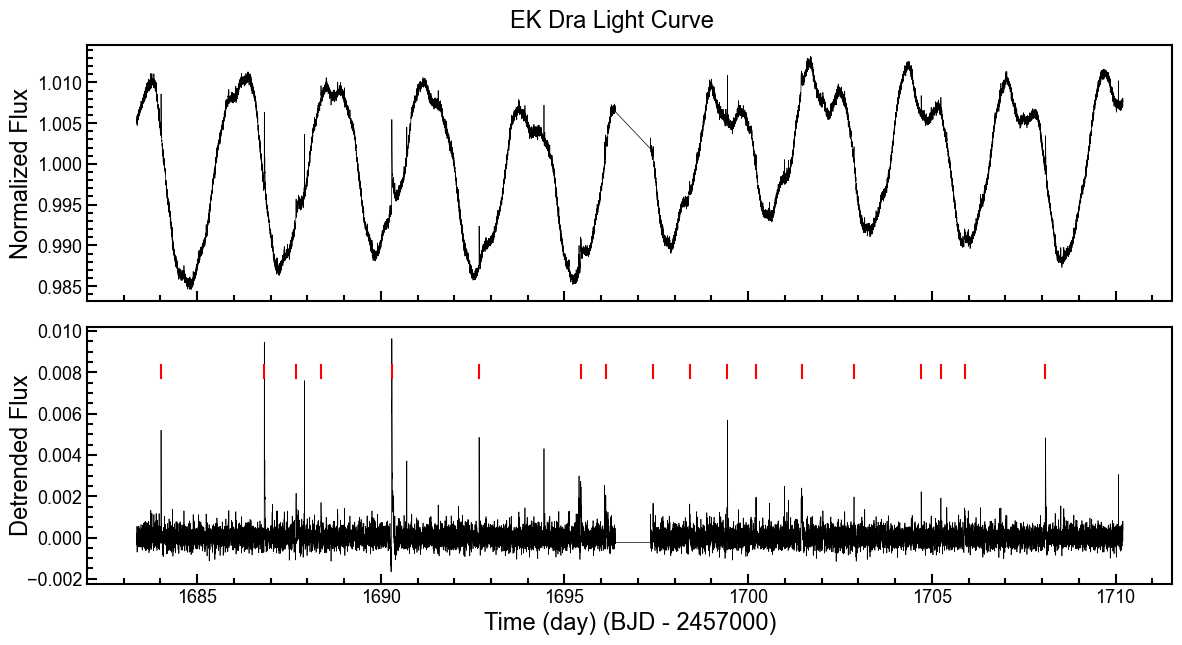

In [11]:
import matplotlib.pyplot as plt

# Paper-quality settings
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

# High-quality plot for a representative sector
sample = list(detectors.values())[0]
sample.plt_flare(
    title="EK Dra Light Curve",
    save_path=str(PROJECT_ROOT / "outputs" / "EK_Dra_lightcurve.pdf")
)


/var/folders/lt/sr85xl355blc7pp9bb174r4h0000gn/T/ipykernel_35693/1169029904.py:26: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



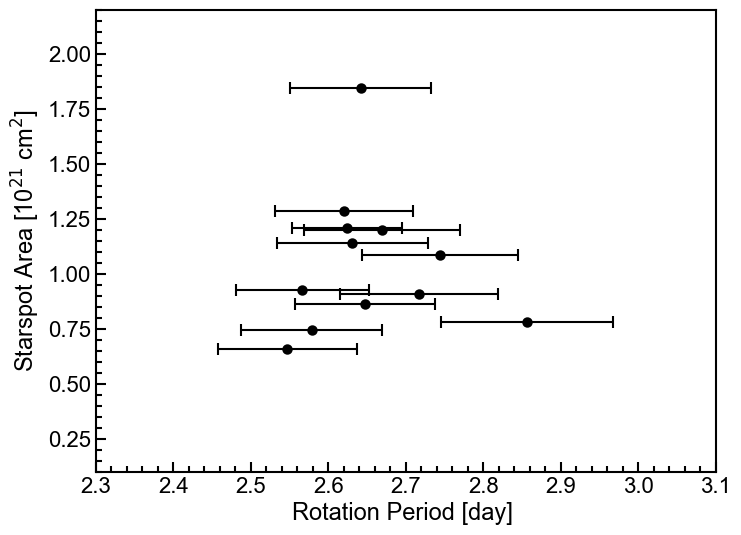

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['xtick.major.width'] = 1.5#x-axis major tick line width
plt.rcParams['ytick.major.width'] = 1.5#y-axis major tick line width
plt.rcParams['axes.linewidth'] = 1.5# Axis line width (edge linewidth)
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"]=True
plt.rcParams["ytick.minor.visible"]=True
plt.rcParams['xtick.minor.width'] = 1.5#x-axis major tick line width
plt.rcParams['ytick.minor.width'] = 1.5#y-axis major tick line width
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in' # x axis in
plt.rcParams['ytick.direction'] = 'in' # y axis in
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(FlareDetector_EK_Dra.array_per, FlareDetector_EK_Dra.array_starspot/1e17, yerr = None, xerr = FlareDetector_EK_Dra.array_per_err, marker="o" ,color="black", ls="none", ms=6, capsize=4, zorder=1, mew=1.5)
plt.plot( FlareDetector_EK_Dra.array_per, FlareDetector_EK_Dra.array_starspot/1e17, zorder=0, color="black", ls="none")
plt.xlabel(f'Rotation Period [day] ', fontsize=17)
plt.ylabel(r"Starspot Area [10$^{21}$ cm$^{2}$]", size=17)
plt.xlim([2.3, 3.1])
plt.ylim([0.1, 2.2])
plt.tick_params(labelsize=16)
leg = plt.legend(loc='upper right', fontsize=16)
leg.get_frame().set_alpha(0)  # Make the background fully transparent
save_path = str(PROJECT_ROOT / "outputs" / "figures" / "ekdra_period_vs_spotarea.pdf")
plt.savefig(save_path, format='pdf', bbox_inches='tight')
plt.show()
